### 📘 Aggrigator: Interactive Guide

Welcome to the **Aggrigator** tutorial notebook!

In this walkthrough, you'll learn how to:
- Explore and apply different **aggregation strategies** to uncertainty maps.
- Evaluate and compare the output of these strategies.
- Save results for analysis.
- Visualize summary results easily.

> Uncertainty aggregation helps you reduce complex per-pixel predictions to single-number scores, enabling easier model evaluation and comparison.


### 🧰 Setup & Imports

In [16]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2
from aggrigator.methods import AggregationMethods as am
from aggrigator.strategylist import StrategyList
from aggrigator.summary import AggregationSummary
from aggrigator.uncertainty_maps import UncertaintyMap
from aggrigator.datasets import generate_random_binary_array_with_squares


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



### 🔧 Generate Example Uncertainty Maps

We'll use a small synthetic dataset to illustrate the aggregation methods. Each array contains a binary uncertainty map with randomly placed squares.

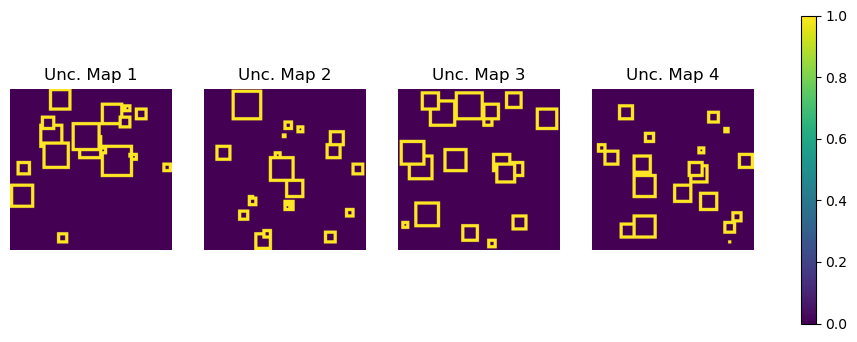

In [3]:
# DATA
N = 4
# Create a list of uncertainty arrays
uncertainty_arrays = [generate_random_binary_array_with_squares(shape=(100, 100), num_squares=20, square_size_mean=10) for _ in range(N)] 

# Plot arrays
fig, axs = plt.subplots(1, N, figsize=(12, 4))
for i, array in enumerate(uncertainty_arrays):
    axs[i].imshow(array, cmap='viridis')
    axs[i].set_title(f"Unc. Map {i+1}")
    axs[i].axis('off')
fig.colorbar(axs[0].get_children()[0], ax=axs.ravel().tolist())
plt.show()

### 📦 Wrap Arrays into UncertaintyMap Objects

We’ll wrap each array in an `UncertaintyMap` object so they can be used with Aggrigator’s aggregation methods.

In [4]:
# Define uncertainty map objects containing additional information:
# array: the uncertainty map array
# mask (optional):the predicted segmentation mask corresponding to the uncertainty map
# name (optional): a name for the uncertainty map

unc_maps = [UncertaintyMap(array=array, mask=None, name=f"Map {idx}") for idx, array in enumerate(uncertainty_arrays)]

### ⚙️ Apply Aggregation Strategies

Now let’s apply some basic strategies to a single uncertainty map to see what they do.


In [5]:
unc_map = unc_maps[0]
# Global Average
mean = am.mean(unc_map, None) # Include None if aggrgegation strategy is parameter free.
# Above Threshoold Average
threshold = 0.7
ata = am.above_threshold_mean(unc_map, threshold)
# Above Quantile Average
quantile = 0.7
aqa = am.above_quantile_mean(unc_map, quantile)

print(f"Mean: {mean}")
print(f"Above Threshold Average: {ata}")
print(f"Above Quantile Average: {aqa}")

Mean: 0.1099
Above Threshold Average: 1.0
Above Quantile Average: 0.1099


### 📊 Compare Strategies Over Multiple Maps

You can compare strategies across all maps at once using an `AggregationSummary`.


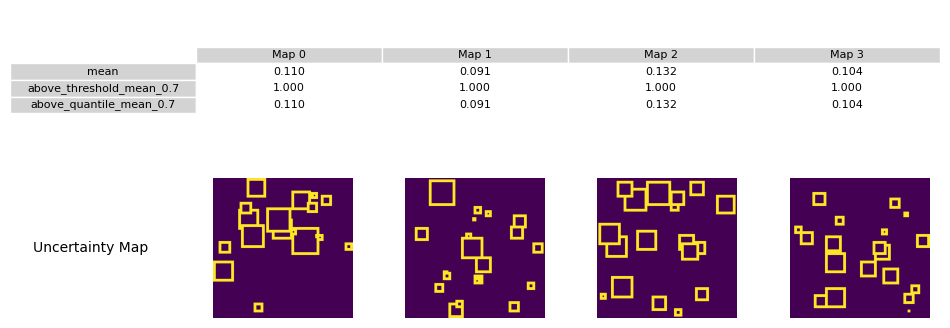

,Name,Map 0,Map 1,Map 2,Map 3
0,mean,0.1099,0.0911,0.1317,0.1043
1,above_threshold_mean_0.7,1.0000,1.0000,1.0000,1.0000
2,above_quantile_mean_0.7,0.1099,0.0911,0.1317,0.1043


In [6]:
strategy_list = [(am.mean, None), (am.above_threshold_mean, 0.7), (am.above_quantile_mean, 0.7)]


summary = AggregationSummary(strategy_list)
results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=True)

# NOTE: Results are stored in a dataframe
results 

### 📈 Analyze a Strategy Across Parameters

Let's see how the quantile threshold affects results.

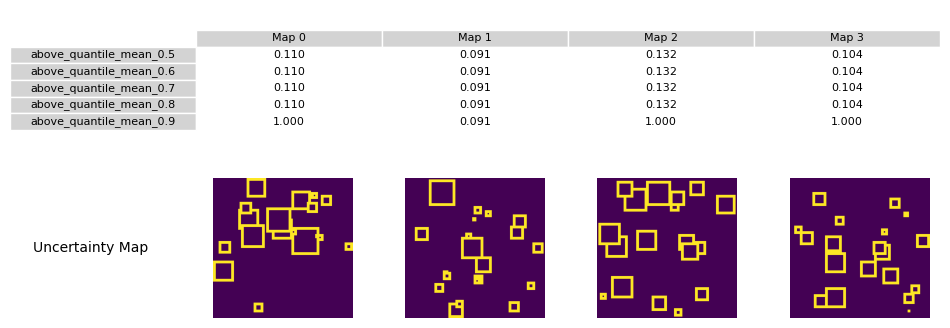

,Name,Map 0,Map 1,Map 2,Map 3
0,above_quantile_mean_0.5,0.1099,0.0911,0.1317,0.1043
1,above_quantile_mean_0.6,0.1099,0.0911,0.1317,0.1043
2,above_quantile_mean_0.7,0.1099,0.0911,0.1317,0.1043
3,above_quantile_mean_0.8,0.1099,0.0911,0.1317,0.1043
4,above_quantile_mean_0.9,1.0000,0.0911,1.0000,1.0000


In [7]:
# Use aggregation summary to compare one strategy across varying parameters
quantiles = [0.5, 0.6, 0.7, 0.8, 0.9]
strategy_list = [(am.above_quantile_mean, quantile) for quantile in quantiles]

summary = AggregationSummary(strategy_list)
results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=True)

# NOTE: Results are stored in a dataframe
results 

### 🧩 Using Segmentation Masks

You can optionally attach segmentation masks to uncertainty maps to enable class-aware aggregation.


In [8]:
# Using the same data for both mask and array for illustration
arrays = uncertainty_arrays
masks = uncertainty_arrays  # typically this would be model predictions
names = [f"Map {idx}" for idx in range(len(arrays))]

unc_maps = [
    UncertaintyMap(array=array, mask=mask, name=name)
    for array, mask, name in zip(arrays, masks, names)
]

### 🎯 Class-Aware Aggregation

You can now apply methods that aggregate uncertainty separately for different classes (e.g., background and foreground).

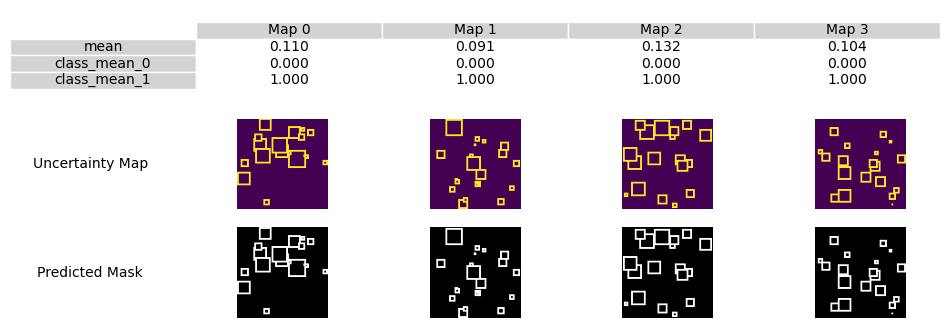

,Name,Map 0,Map 1,Map 2,Map 3
0,mean,0.1099,0.0911,0.1317,0.1043
1,class_mean_0,0.0000,0.0000,0.0000,0.0000
2,class_mean_1,1.0000,1.0000,1.0000,1.0000


In [9]:
strategy_list = [
    (am.mean, None),
    (am.class_mean, 0),  # class 0 = background
    (am.class_mean, 1),  # class 1 = foreground
]

summary = AggregationSummary(strategy_list)
results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=True)

results

### Spatial Decomposition

Spatial decomposition allows you to analyze patterns in your uncertainty maps using spatial measures such as Moran’s I, Entropy, and Edge Density Score (EDS). These measures help distinguish between areas with strong spatial structure and areas with weak or no spatial patterns.

By applying spatial decomposition, any uncertainty map can be split into two components:

- One that captures spatially structured regions (e.g. clustered, edged, or uniformly distributed areas).
- One that represents spatially unstructured regions (e.g. noise, randomness, or flat areas).

This process also yields a spatial measure score the **Spatial Ratio**, which quantifies the proportion of uncertainty concentrated in spatially structured regions. In other words, it tells you how much of the uncertainty has a spatial signature.
For example:

**Moran’s I**
- Spatial Ratio = 1: Strong spatial clustering in the uncertainty map.
- Spatial Ratio = 0: No spatial autocorrelation, the uncertainty is randomly distributed.

**Edge Density Score (EDS)**
- Spatial Ratio = 1: High presence of edge, uncertainty is concentrated along boundaries or transitions.
- Spatial Ratio = 0: No edge structure, uncertainty is evenly flat.

**Entropy**
- Spatial Ratio = 1: Uniform distribution, uncertainty values are spread out evenly.
- Spatial Ratio = 0: Low diversity, uncertainty is concentrated in specific values or regions (e.g. high certainty in most of the map).

In [19]:
from aggrigator.spatial_decomposition import spatial_decomposition

x = np.random.rand(100, 100)
x[10:25, 10:25] = 1
x[30:45, 30:45] = 1
x[50:65, 50:65] = 1
x[70:85, 70:85] = 1
unc_map = UncertaintyMap(x, name='spatial_test')

spatial_measure = "moran"
window_size = 3
decomposition = spatial_decomposition(unc_map, window_size=window_size, spatial_measure=spatial_measure)
high_measure_map, low_measure_map, local_measure_weights, high_spatial_mass_ratio = decomposition

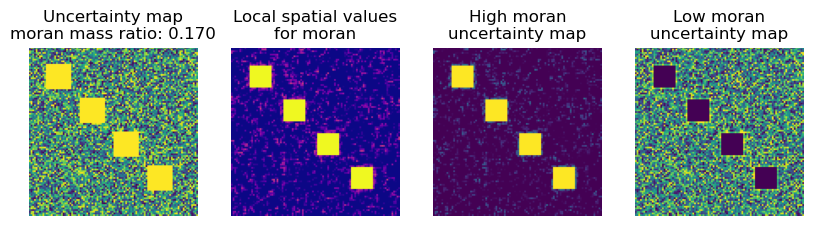

In [20]:
# Plot the decomposition
plt.figure(figsize=(10, 5))

# The original uncertainty map
plt.subplot(1, 4, 1)
plt.imshow(unc_map.array, cmap='viridis', vmin=0,vmax=1)
plt.axis('off')
plt.title(f'Uncertainty map\n{spatial_measure} mass ratio: {high_spatial_mass_ratio:.3f}')

# The pixelwise local spatial measure between 0 and 1.
# Each local measure acts as a pixelwise weight for the original uncertainty map.
plt.subplot(1, 4, 2)
plt.imshow(local_measure_weights, cmap='plasma', vmin=0,vmax=1)
plt.title(f'Local spatial values\nfor {spatial_measure}')
plt.axis('off')

# The high spatial uncertainty map, i.e. the uncertainty map weighted by the local spatial measure.
# This map captures uncertainty present in patterns with high spatial measure,
# e.g. clusters of similar values for Moran's I or edges for EDS.
plt.subplot(1, 4, 3)
plt.imshow(high_measure_map.array, cmap='viridis', vmin=0,vmax=1)
plt.title(f'High {spatial_measure}\nuncertainty map')
plt.axis('off')

# The low spatial uncertainty map, i.e. the uncertainty map weighted by 1 - the local spatial measure.
# This map captures uncertainty present in patterns with low spatial measure,
# e.g. random noise for Moran's I or flat areas for EDS.
plt.subplot(1, 4, 4)
plt.imshow(low_measure_map.array, cmap='viridis', vmin=0,vmax=1)
plt.title(f'Low {spatial_measure}\nuncertainty map')
plt.axis('off')
plt.show() 

In [24]:
x = np.zeros((100, 100))
x[10:25, 10:25] = 1
x[30:45, 30:45] = 1
x[50:65, 50:65] = 1
x[70:85, 70:85] = 1
unc_map = UncertaintyMap(x, name='spatial_test')

spatial_measure = "eds"
window_size = 3
decomposition = spatial_decomposition(unc_map, window_size=window_size, spatial_measure=spatial_measure)
high_measure_map, low_measure_map, local_measure_weights, high_spatial_mass_ratio = decomposition

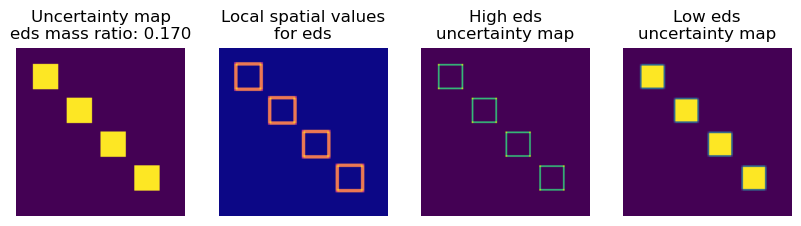

In [25]:
# Plot the decomposition
plt.figure(figsize=(10, 5))

# The original uncertainty map
plt.subplot(1, 4, 1)
plt.imshow(unc_map.array, cmap='viridis', vmin=0,vmax=1)
plt.axis('off')
plt.title(f'Uncertainty map\n{spatial_measure} mass ratio: {high_spatial_mass_ratio:.3f}')

# The pixelwise local spatial measure between 0 and 1.
# Each local measure acts as a pixelwise weight for the original uncertainty map.
plt.subplot(1, 4, 2)
plt.imshow(local_measure_weights, cmap='plasma', vmin=0,vmax=1)
plt.title(f'Local spatial values\nfor {spatial_measure}')
plt.axis('off')

# The high spatial uncertainty map, i.e. the uncertainty map weighted by the local spatial measure.
# This map captures uncertainty present in patterns with high spatial measure,
# e.g. clusters of similar values for Moran's I or edges for EDS.
plt.subplot(1, 4, 3)
plt.imshow(high_measure_map.array, cmap='viridis', vmin=0,vmax=1)
plt.title(f'High {spatial_measure}\nuncertainty map')
plt.axis('off')

# The low spatial uncertainty map, i.e. the uncertainty map weighted by 1 - the local spatial measure.
# This map captures uncertainty present in patterns with low spatial measure,
# e.g. random noise for Moran's I or flat areas for EDS.
plt.subplot(1, 4, 4)
plt.imshow(low_measure_map.array, cmap='viridis', vmin=0,vmax=1)
plt.title(f'Low {spatial_measure}\nuncertainty map')
plt.axis('off')
plt.show() 